# Purpose
* porting the [importance sampling from pyro](https://pyro.ai/examples/inclined_plane.html) to numpyro
* pyro importance sampling with a cpuonly PyTorch took forever

*Copyright (c) 2017-2019 Uber Technologies, Inc.*
*SPDX-License-Identifier: Apache-2.0*

In [1]:
import numpy as np
import jax
from jax import jit, lax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

import numpyro
from numpyro.distributions import Normal, Uniform, LogNormal, Gamma
from numpyro.infer import MCMC, NUTS, SA

In [2]:
key = jax.random.PRNGKey(2)
key

DeviceArray([0, 2], dtype=uint32)

**Problem Story** - Samantha really likes physics---but she likes Pyro even more. Instead of using
calculus to do her physics lab homework (which she could easily do), she's going
to use bayesian inference. The problem setup is as follows. In lab she observed
a little box slide down an inclined plane (length of 2 meters and with an incline of
30 degrees) 20 times. Each time she measured and recorded the descent time. The timing
device she used has a known measurement error of 20 milliseconds. Using the observed
data, she wants to infer the coefficient of friction $\mu$ between the box and the inclined
plane. She already has (deterministic) python code that can simulate the amount of time
that it takes the little box to slide down the inclined plane as a function of $\mu$. Using
Pyro, she can reverse the simulator and infer $\mu$ from the observed descent times.

| ![ppl_inference](https://bookdown.org/robertness/causalml/docs/fig/inference.png) |
|:--:|
| **Fig. 1.** The original source of the image is from [Kevin Smith - tutorial: Probabilistic Programming](https://youtu.be/9SEIYh5BCjc?t=894), but the link is from [Robert Ness's Lecture Notes for Causality in Machine Learning](https://bookdown.org/robertness/causalml/docs/tutorial-on-deep-probabilitic-modeling-with-pyro.html)|

In [3]:
little_g = 9.8  # m/s/s
mu0 = 0.12  # actual coefficient of friction in the experiment
time_measurement_sigma = 0.02  # observation noise in seconds (known quantity)

**Simulator** - the forward simulator, which does numerical integration of the equations of motion in steps of size dt, and optionally includes measurement noise

In [4]:
def _body(info):
    displacement, length, velocity, dt, acceleration, T = info
    displacement += velocity * dt
    velocity += acceleration * dt
    T += dt
    
    return displacement, length, velocity, dt, acceleration, T

def _conf(info):
    displacement, length, _, _, _, _ = info
    return displacement < length

def slide(displacement, length, velocity, dt, acceleration, T):
    info = (displacement, length, velocity, dt, acceleration, T)
    res = lax.while_loop(_conf, _body, info)
    return res[-1]

# length=2.0, phi=jnp.pi / 6.0, dt=0.005
@jit
def jax_simulate(mu, key, noise_sigma, length, phi, dt):
    T = jnp.zeros(())
    velocity = jnp.zeros(())
    displacement = jnp.zeros(())
    acceleration = (little_g * jnp.sin(phi)) - (little_g * jnp.cos(phi)) * mu
    
    T = slide(displacement, length, velocity, dt, acceleration, T)

    return T + noise_sigma * jax.random.normal(key, ())

In [5]:
print("First call: ", jax_simulate(mu0, key, time_measurement_sigma, 2.0, jnp.pi / 6.0, 0.005))
print ("Second call: ", jax_simulate(0.14, key, time_measurement_sigma, 2.0, jnp.pi / 6.0, 0.005))
print ("Third call, different type: ", jax_simulate(0, key, time_measurement_sigma, 2.0, jnp.pi / 6.0, 0.005))

First call:  1.0161669
Second call:  1.0411669
Third call, different type:  0.906167


In [6]:
# analytic formula that the simulator above is computing via
# numerical integration (no measurement noise)
@jax.jit
def analytic_T(mu, length=2.0, phi=jnp.pi / 6.0):
    numerator = 2.0 * length
    denominator = little_g * (jnp.sin(phi) - mu * jnp.cos(phi))
    return jnp.sqrt(numerator / denominator)

In [7]:
# generate N_obs observations using simulator and the true coefficient of friction mu0
print("generating simulated data using the true coefficient of friction %.3f" % mu0)
N_obs = 20

generating simulated data using the true coefficient of friction 0.120


In [8]:
keys = jax.random.split(key, N_obs)

In [9]:
observed_data = jnp.array([jax_simulate(mu0, key, time_measurement_sigma, 2.0, jnp.pi / 6.0, 0.005) for key in keys])
observed_mean = jnp.mean(observed_data)
observed_mean

DeviceArray(1.0271555, dtype=float32)

In [10]:
w = lambda info: jax.lax.while_loop(_conf, _body, info)

In [11]:
def numpyro_model(observed_data, measurment_sigma):
    length = 2.0
    phi = jnp.pi / 6.0
    dt = 0.005
    mu = numpyro.sample("mu", Uniform(0.0, 1.0))
    
    with numpyro.plate("data_loop", len(observed_data)):
        T = jnp.zeros(())
        velocity = jnp.zeros(())
        displacement = jnp.zeros(())
        acceleration = (little_g * jnp.sin(phi)) - (little_g * jnp.cos(phi)) * mu
        info = (displacement, length, velocity, dt, acceleration, T)
        res = jax.lax.cond(acceleration <= 0, info, lambda _: (0.,0.,0.,0.,0.,1.0e5), info, w)
        T_simulated = res[-1]
        numpyro.sample("obs", Normal(T_simulated, measurment_sigma), obs=observed_data)
        
    return mu

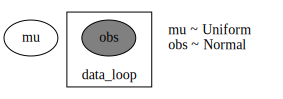

In [12]:
numpyro.render_model(numpyro_model, model_args=(observed_data,time_measurement_sigma), render_distributions=True)

In [13]:
for depth in (10, 13, 15):
    nuts_kernel = NUTS(numpyro_model,forward_mode_differentiation=True, max_tree_depth=depth)
    mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=4, chain_method='parallel', progress_bar=True)
    mcmc.run(key, observed_data, time_measurement_sigma, extra_fields=('potential_energy',))
    print(f"--" * 25 + f"max_tree_depth={depth}" + f"--" * 25)
    mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:02<00:00, 655.22it/s, 1023 steps of size 1.37e-03. acc. prob=0.87]


--------------------------------------------------max_tree_depth=10--------------------------------------------------

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.13      0.00      0.13      0.12      0.13    547.18      1.00

Number of divergences: 0


/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:17<00:00, 84.98it/s, 8191 steps of size 9.83e-05. acc. prob=0.91]
/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnin

--------------------------------------------------max_tree_depth=13--------------------------------------------------

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.13      0.00      0.13      0.12      0.13    406.83      1.01

Number of divergences: 0


sample: 100%|██████████| 1500/1500 [01:11<00:00, 21.06it/s, 32767 steps of size 3.55e-05. acc. prob=0.87]


--------------------------------------------------max_tree_depth=15--------------------------------------------------

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.13      0.00      0.13      0.12      0.13    462.92      1.01

Number of divergences: 0


In [14]:
ds = az.from_numpyro(mcmc)

In [15]:
inferred_mu = ds.posterior["mu"].mean().item()
inferred_mu_uncertainty = ds.posterior["mu"].std().item()
print("the coefficient of friction inferred by pyro is %.3f +- %.3f" %
          (inferred_mu, inferred_mu_uncertainty))

the coefficient of friction inferred by pyro is 0.126 +- 0.004


In [16]:
print("the mean observed descent time in the dataset is: %.4f seconds" % observed_mean)
print("the (forward) simulated descent time for the inferred (mean) mu is: %.4f seconds" %
          jax.jit(jax_simulate)(inferred_mu, key, 0., 2.0, jnp.pi / 6.0, 0.005))
print(("disregarding measurement noise, elementary calculus gives the descent time\n" +
           "for the inferred (mean) mu as: %.4f seconds") % analytic_T(inferred_mu))

the mean observed descent time in the dataset is: 1.0272 seconds
the (forward) simulated descent time for the inferred (mean) mu is: 1.0250 seconds
disregarding measurement noise, elementary calculus gives the descent time
for the inferred (mean) mu as: 1.0217 seconds


array([[<AxesSubplot:title={'center':'mu'}>]], dtype=object)

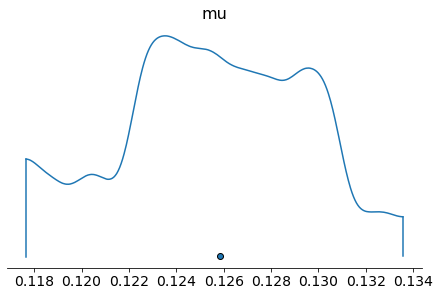

In [17]:
az.plot_density(ds.posterior, var_names=["mu"])

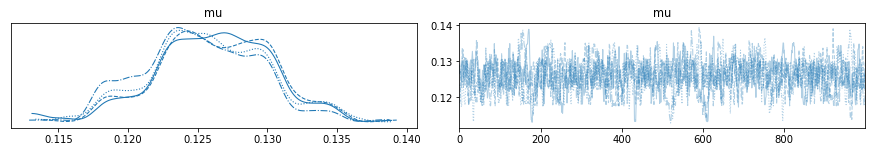

In [18]:
az.plot_trace(ds)
plt.show()

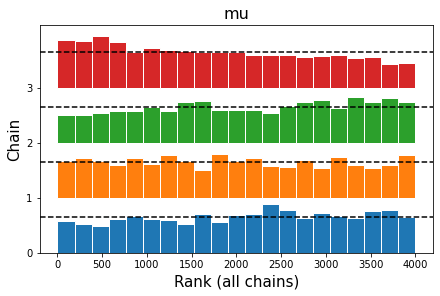

In [19]:
az.plot_rank(ds)
plt.show()

In [20]:
def numpyro_model(observed_data, measurment_sigma):
    length = 2.0
    phi = jnp.pi / 6.0
    dt = 0.005
    mu = numpyro.sample("mu", Uniform(0.0, 1.0))
    
    with numpyro.plate("data_loop", len(observed_data)):
        T = jnp.zeros(())
        velocity = jnp.zeros(())
        displacement = jnp.zeros(())
        acceleration = (little_g * jnp.sin(phi)) - (little_g * jnp.cos(phi)) * mu
        info = (displacement, length, velocity, dt, acceleration, T)
        res = jax.lax.cond(acceleration <= 0, info, lambda _: (0.,0.,0.,0.,0.,1.0e5), info, w)
        T_simulated = res[-1]
        numpyro.sample("obs", Normal(T_simulated, measurment_sigma), obs=observed_data)
        
    return mu

sa_kernel = SA(numpyro_model)
num_samples, num_chains = 4000, 10
mcmc = MCMC(sa_kernel, num_warmup=2000, num_samples=num_samples, num_chains=num_chains, chain_method='parallel', progress_bar=False)
mcmc.run(key, observed_data, time_measurement_sigma, extra_fields=('potential_energy',))

for row in mcmc.get_samples()["mu"].reshape((num_chains,num_samples)):
    inferred_mu = row.mean().item()
    inferred_mu_uncertainty = row.std().item()
    print("the coefficient of friction inferred by pyro is %.3f +- %.3f" %
              (inferred_mu, inferred_mu_uncertainty))


mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(


the coefficient of friction inferred by pyro is 0.129 +- 0.010
the coefficient of friction inferred by pyro is 0.799 +- 0.000
the coefficient of friction inferred by pyro is 0.951 +- 0.000
the coefficient of friction inferred by pyro is 0.126 +- 0.004
the coefficient of friction inferred by pyro is 0.127 +- 0.004
the coefficient of friction inferred by pyro is 0.273 +- 0.022
the coefficient of friction inferred by pyro is 0.125 +- 0.004
the coefficient of friction inferred by pyro is 0.126 +- 0.004
the coefficient of friction inferred by pyro is 0.543 +- 0.000
the coefficient of friction inferred by pyro is 0.398 +- 0.004

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.36      0.29      0.20      0.12      0.95      5.01     54.65

Number of divergences: 5


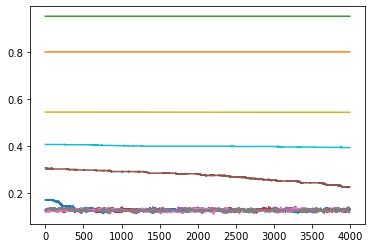

In [21]:
for row in mcmc.get_samples()["mu"].reshape((num_chains,num_samples)):
    plt.plot(row)

plt.show()

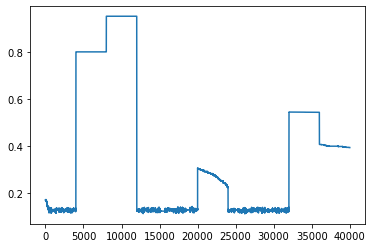

In [22]:
plt.plot(mcmc.get_samples()["mu"])

**Prior**

From [Wikipedia on PTFE](https://en.wikipedia.org/wiki/Polytetrafluoroethylene):
*The coefficient of friction of plastics is usually measured against polished steel.[24] PTFE's coefficient of friction is **0.05 to 0.10**,[15] which is the **third-lowest of any known solid material** (aluminium magnesium boride (BAM) being the first, with a coefficient of friction of 0.02; diamond-like carbon being second-lowest at 0.05)*

Also largets value from the table for both static and sliding is **1.4 for Ag** and **3.0 for Pt**, respectfully [Wikipedia on Friction](https://en.wikipedia.org/wiki/Friction)

I guess the school's physics lab could be doing the experiment with tracks made of Pt or Ag.... but I highly doubt

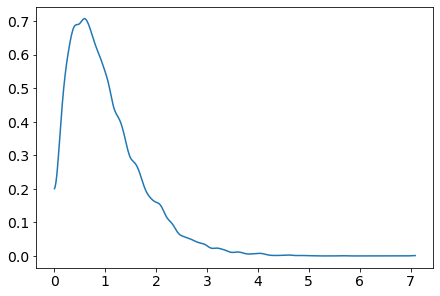

In [23]:
b = Gamma(2, 2).sample(jax.random.PRNGKey(12), (int(1e4),))
az.plot_kde(b)
plt.show()

In [24]:
def numpyro_model(observed_data, measurment_sigma):
    length = 2.0
    phi = jnp.pi / 6.0
    dt = 0.005
    mu = numpyro.sample("mu", Gamma(2, 2))
    
    with numpyro.plate("data_loop", len(observed_data)):
        T = jnp.zeros(())
        velocity = jnp.zeros(())
        displacement = jnp.zeros(())
        acceleration = (little_g * jnp.sin(phi)) - (little_g * jnp.cos(phi)) * mu
        info = (displacement, length, velocity, dt, acceleration, T)
        res = jax.lax.cond(acceleration <= 0, info, lambda _: (0.,0.,0.,0.,0.,1.0e5), info, w)
        T_simulated = res[-1]
        numpyro.sample("obs", Normal(T_simulated, measurment_sigma), obs=observed_data)
        
    return mu

for depth in (10, 13, 15):
    nuts_kernel = NUTS(numpyro_model,forward_mode_differentiation=True, max_tree_depth=depth)
    mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=4, chain_method='parallel', progress_bar=True)
    mcmc.run(key, observed_data, time_measurement_sigma, extra_fields=('potential_energy',))
    print(f"--" * 25 + f"max_tree_depth={depth}" + f"--" * 25)
    mcmc.print_summary()
    
ds = az.from_numpyro(mcmc)
inferred_mu = ds.posterior["mu"].mean().item()
inferred_mu_uncertainty = ds.posterior["mu"].std().item()
print("the coefficient of friction inferred by pyro is %.3f +- %.3f" %
          (inferred_mu, inferred_mu_uncertainty))
print("the mean observed descent time in the dataset is: %.4f seconds" % observed_mean)
print("the (forward) simulated descent time for the inferred (mean) mu is: %.4f seconds" %
          jax.jit(jax_simulate)(inferred_mu, key, 0., 2.0, jnp.pi / 6.0, 0.005))
print(("disregarding measurement noise, elementary calculus gives the descent time\n" +
           "for the inferred (mean) mu as: %.4f seconds") % analytic_T(inferred_mu))

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|██████████| 1500/1500 [00:02<00:00, 592.26it/s, 1023 steps of size 7.93e-05. acc. prob=0.92]
/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warni

--------------------------------------------------max_tree_depth=10--------------------------------------------------

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.14      0.03      0.13      0.12      0.20      2.63      4.39

Number of divergences: 0


sample: 100%|██████████| 1500/1500 [00:16<00:00, 93.35it/s, 8191 steps of size 2.46e-05. acc. prob=0.90] 
/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(


--------------------------------------------------max_tree_depth=13--------------------------------------------------

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.13      0.00      0.13      0.12      0.13    354.46      1.01

Number of divergences: 0


sample: 100%|██████████| 1500/1500 [01:01<00:00, 24.44it/s, 32767 steps of size 4.25e-05. acc. prob=0.86]


--------------------------------------------------max_tree_depth=15--------------------------------------------------

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.13      0.00      0.13      0.12      0.13    521.95      1.01

Number of divergences: 0
the coefficient of friction inferred by pyro is 0.126 +- 0.004
the mean observed descent time in the dataset is: 1.0272 seconds
the (forward) simulated descent time for the inferred (mean) mu is: 1.0250 seconds
disregarding measurement noise, elementary calculus gives the descent time
for the inferred (mean) mu as: 1.0220 seconds


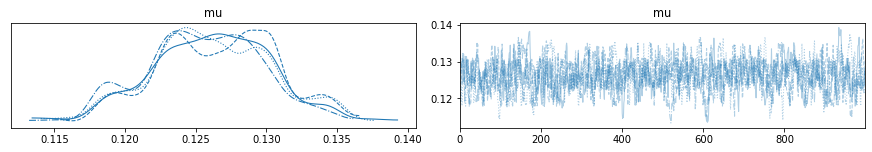

In [25]:
az.plot_trace(ds)
plt.show()

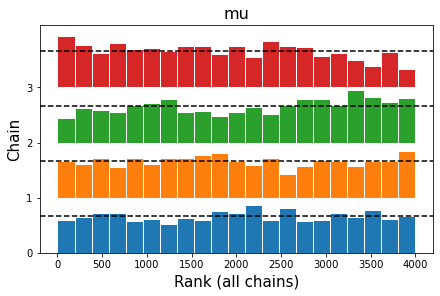

In [26]:
az.plot_rank(ds)
plt.show()

In [27]:
def numpyro_model(observed_data, measurment_sigma):
    length = 2.0
    phi = jnp.pi / 6.0
    dt = 0.005
    mu = numpyro.sample("mu", Gamma(2, 2))
    
    with numpyro.plate("data_loop", len(observed_data)):
        T = jnp.zeros(())
        velocity = jnp.zeros(())
        displacement = jnp.zeros(())
        acceleration = (little_g * jnp.sin(phi)) - (little_g * jnp.cos(phi)) * mu
        info = (displacement, length, velocity, dt, acceleration, T)
        res = jax.lax.cond(acceleration <= 0, info, lambda _: (0.,0.,0.,0.,0.,1.0e5), info, w)
        T_simulated = res[-1]
        numpyro.sample("obs", Normal(T_simulated, measurment_sigma), obs=observed_data)
        
    return mu

sa_kernel = SA(numpyro_model)
num_samples, num_chains = 4000, 10
mcmc = MCMC(sa_kernel, num_warmup=2000, num_samples=num_samples, num_chains=num_chains, chain_method='parallel', progress_bar=False)
mcmc.run(key, observed_data, time_measurement_sigma, extra_fields=('potential_energy',))

for row in mcmc.get_samples()["mu"].reshape((num_chains,num_samples)):
    inferred_mu = row.mean().item()
    inferred_mu_uncertainty = row.std().item()
    print("the coefficient of friction inferred by pyro is %.3f +- %.3f" %
              (inferred_mu, inferred_mu_uncertainty))


mcmc.print_summary()

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(


the coefficient of friction inferred by pyro is 0.181 +- 0.031
the coefficient of friction inferred by pyro is 3.983 +- 0.000
the coefficient of friction inferred by pyro is 19.347 +- 0.000
the coefficient of friction inferred by pyro is 0.126 +- 0.004
the coefficient of friction inferred by pyro is 0.127 +- 0.004
the coefficient of friction inferred by pyro is 1.114 +- 0.000
the coefficient of friction inferred by pyro is 0.126 +- 0.004
the coefficient of friction inferred by pyro is 0.126 +- 0.004
the coefficient of friction inferred by pyro is 1.747 +- 0.000
the coefficient of friction inferred by pyro is 0.995 +- 0.000

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      2.79      5.64      0.62      0.12     19.35      5.00    882.02

Number of divergences: 0


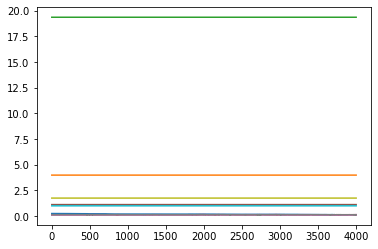

In [28]:
for row in mcmc.get_samples()["mu"].reshape((num_chains,num_samples)):
    plt.plot(row)

plt.show()

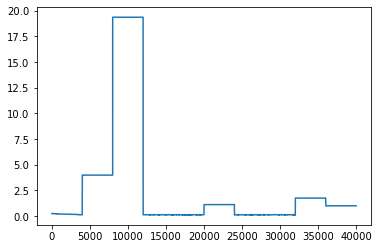

In [29]:
plt.plot(mcmc.get_samples()["mu"])